In [32]:
import pandas as pd
import tpqoa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [33]:
api = tpqoa.tpqoa("oanda.cfg")

In [34]:
df = api.get_history(instrument = "DE30_EUR", start = "2022-07-01", end = "2023-01-04",
                     granularity = "H1", price = "B")

df = df.drop(["complete"],axis = 1)

df.index = pd.to_datetime(df.index).date
df.index = pd.to_datetime(df.index)

# df["day"] = df.index.dayofweek
# days = {6:1,0:2,1:3,2:4,3: 5}
# df['day'] = df['day'].apply(lambda x: days[x])

df.insert(4, 'c', df.pop('c'))

df


,volume,o,h,l,c
2022-07-01,814,12817.9,12834.4,12780.9,12790.9
2022-07-01,1260,12790.9,12799.9,12743.9,12764.9
2022-07-01,1115,12765.9,12791.9,12713.9,12727.9
2022-07-01,1510,12728.9,12731.9,12666.9,12677.9
2022-07-01,1143,12677.9,12694.9,12651.9,12673.9
...,...,...,...,...,...
2023-01-03,6577,14258.3,14265.3,14160.8,14166.7
2023-01-03,4804,14166.8,14196.8,14153.8,14175.7
2023-01-03,4157,14174.7,14202.7,14167.7,14194.7
2023-01-03,4964,14193.8,14217.7,14157.8,14197.7


In [35]:
scaler = MinMaxScaler(feature_range=(0,1))
data = np.array(df)
data = data.astype('float32')
data = scaler.fit_transform(data)

In [36]:
data

array([[0.03828357, 0.3541088 , 0.3442688 , 0.3544011 , 0.34476852],
       [0.06000682, 0.3446226 , 0.33195305, 0.34111404, 0.335639  ],
       [0.05294432, 0.33583927, 0.32909727, 0.33034086, 0.32264757],
       ...,
       [0.20111051, 0.8307977 , 0.83272076, 0.85240793, 0.8376756 ],
       [0.24041693, 0.8375082 , 0.83807516, 0.84885263, 0.8387289 ],
       [0.24976864, 0.838562  , 0.8402171 , 0.85854864, 0.84715605]],
      dtype=float32)

In [37]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [38]:
lookback = 10

reframed = series_to_supervised(data, lookback, 2)
reframed.drop(reframed.iloc[:,55:59], axis=1, inplace=True)
reframed

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var1(t-9),var2(t-9),var3(t-9),var4(t-9),var5(t-9),...,var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var5(t+1)
10,0.038284,0.354109,0.344269,0.354401,0.344769,0.060007,0.344623,0.331953,0.341114,0.335639,...,0.350595,0.350159,0.358100,0.363834,0.148897,0.363244,0.349909,0.345064,0.335639,0.324754
11,0.060007,0.344623,0.331953,0.341114,0.335639,0.052944,0.335839,0.329097,0.330341,0.322648,...,0.363244,0.349909,0.345064,0.335639,0.183527,0.335839,0.323136,0.334651,0.324754,0.341362
12,0.052944,0.335839,0.329097,0.330341,0.322648,0.072184,0.322840,0.307679,0.313463,0.305091,...,0.335839,0.323136,0.334651,0.324754,0.192733,0.324948,0.326956,0.335476,0.341362,0.370751
13,0.072184,0.322840,0.307679,0.313463,0.305091,0.054308,0.304922,0.294471,0.308076,0.303687,...,0.324948,0.326956,0.335476,0.341362,0.400468,0.341109,0.363831,0.344705,0.370751,0.338448
14,0.054308,0.304922,0.294471,0.308076,0.303687,0.069212,0.303868,0.295185,0.310483,0.305091,...,0.341109,0.363831,0.344705,0.370751,0.580537,0.370376,0.360975,0.340504,0.338448,0.337676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,0.026740,0.781014,0.781316,0.803929,0.788272,0.040914,0.788287,0.780959,0.788236,0.775983,...,0.854899,0.868168,0.864725,0.845962,0.387268,0.846467,0.852925,0.849391,0.860253,0.827844
2673,0.040914,0.788287,0.780959,0.788236,0.775983,0.109639,0.776095,0.782065,0.793156,0.790660,...,0.846467,0.852925,0.849391,0.860253,0.318981,0.860169,0.855067,0.849930,0.827844,0.831004
2674,0.109639,0.776095,0.782065,0.793156,0.790660,0.432224,0.790430,0.839610,0.812188,0.845962,...,0.860169,0.855067,0.849930,0.827844,0.232624,0.828022,0.830615,0.847416,0.831004,0.837676
2675,0.432224,0.790430,0.839610,0.812188,0.845962,0.317374,0.846011,0.870060,0.870112,0.870787,...,0.828022,0.830615,0.847416,0.831004,0.201111,0.830798,0.832721,0.852408,0.837676,0.838729


In [39]:
values = reframed.values

size = 0.8
training_size=int(len(data)*size)
X_train, Y_train=values[:training_size,:-1],values[:training_size, -1]
X_test, Y_test=values[training_size:, :-1],values[training_size: , -1]
X_train =X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [40]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((2142, 1, 55), (2142,), (525, 1, 55), (525,))

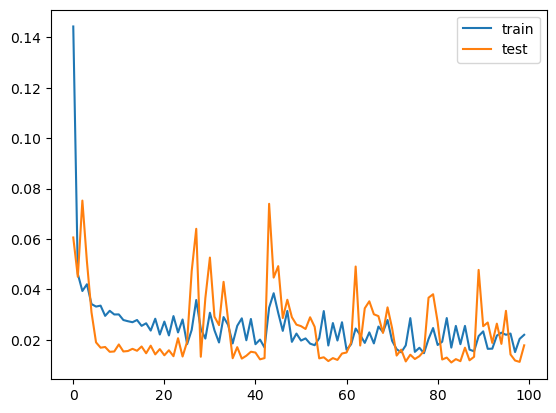

In [41]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, Y_train, epochs=100, batch_size=72, validation_data=(X_test, Y_test), verbose=0, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [42]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [43]:
yhat = model.predict(X_test)

17/17 [==============================] - 0s 1ms/step


In [44]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

In [45]:
X_test.shape, yhat.shape

((525, 55), (525, 1))

In [46]:
inv_yhat = np.concatenate((X_test[:, :4],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

In [47]:
Y_test = Y_test.reshape((len(Y_test), 1))
inv_y = np.concatenate((X_test[:, :4], Y_test), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [48]:
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

r2 = r2_score(inv_y, inv_yhat)*100
print('R2: %.3f ' % r2)

Test RMSE: 62.678
R2: 91.526 


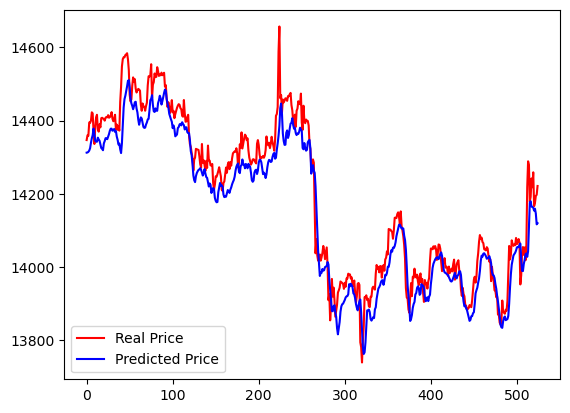

In [49]:
plt.plot(inv_y, color="red", label = "Real Price")
plt.plot(inv_yhat, color="blue", label = "Predicted Price")
plt.legend(["Real Price", "Predicted Price"], loc ="lower left")
plt.show()

In [50]:
inv_yhat[-10:]

array([14176.159, 14179.915, 14165.365, 14164.413, 14162.549, 14154.415,
       14159.741, 14146.358, 14117.006, 14120.237], dtype=float32)